In [1]:
import pandas as pd
import numpy as np
from itertools import product
from ast import literal_eval
import seaborn as sns
import random
import matplotlib.pyplot as plt
import geopandas as gp
from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from collections import Counter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import tqdm
import matplotlib.colors as mcolors
from funding import core

In [2]:
pubs_path="../../data/nf_folder/Data/DerivedData/CleanedRawData/pub.pkl"
region_path="../../data/nf_folder/Data/AdditionalData/cntry_region.xlsx"
world_geo_path="../../data/nf_folder/Data/AdditionalData/world_map_shp/ne_50m_admin_0_countries.shp"

funding_intensity_overall_path = "/u/miaoli/ember_home/dropbox/NationalFunding/Figs/Figs/funding_intensity_overall.pdf"
funding_portfolio_path = "/u/miaoli/ember_home/dropbox/NationalFunding/Figs/Figs/funding_portfolio_region.pdf"
funding_intensity_self_path = "/u/miaoli/ember_home/dropbox/NationalFunding/Figs/Figs/country_exclusive_funding.pdf"

In [3]:
pubs_df=pd.read_pickle(pubs_path)
pubs_df.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[United States, Canada]",[United States],1,1,0,0
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0,0,0
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[Chile, France]",[Chile],1,1,0,0
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1,0,0
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0,0,0


### calculate the funding portofolio of countres

In [10]:
pubs_df.head()

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund
0,60694041,2017,9,1,"[Canada, United States]","[United States, United States]","[United States, Canada]",[United States],1,1,0,0
1,48573156,2012,89,1,[France],Not-Funded,[France],Not-Funded,0,0,0,0
2,55323671,2015,89,1,"[France, Chile]","[Chile, Chile, Chile, Chile, Chile]","[Chile, France]",[Chile],1,1,0,0
3,57633115,2016,31,1,"[Switzerland, United States]",[Switzerland],"[Switzerland, United States]",[Switzerland],1,1,0,0
4,64831413,2018,99,1,[China],"[China, China, China, China, China, China]",[China],[China],1,0,0,0


In [4]:
author_df=pubs_df[['id','author_distinct','funder_distinct']].explode('author_distinct')
author_df.head()

,id,author_distinct,funder_distinct
0,60694041,United States,[United States]
0,60694041,Canada,[United States]
1,48573156,France,Not-Funded
2,55323671,Chile,[Chile]
2,55323671,France,[Chile]


In [5]:
region=pd.read_excel(region_path)
region=region[['cntry','region2']]
region=region.rename(columns={'region2':'region'})

In [6]:
eucntrys = region[region.region=='EU'].cntry.values.tolist()

In [9]:
author_eu = author_df[author_df.author_distinct.isin(eucntrys)]

In [10]:
def assign_type(acntry,funders):
    t='null'
    if funders=='Not-Funded':
        t='Not-Funded'
    elif len(funders)==1 and funders[0]==acntry: #if the author country is the only one funder of the pub
        t='Domestic'
    elif set([acntry, 'EU'])==set(funders):
        t='EU-Domestic'
    elif acntry in funders:
        t='Co-Fund'
    elif acntry not in funders:
        t='Foreign'
    return t
author_eu['fund']=author_eu.apply(lambda x: assign_type(x.author_distinct,x.funder_distinct),axis=1)

/tmp/ipykernel_3105448/1646755606.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  author_eu['fund']=author_eu.apply(lambda x: assign_type(x.author_distinct,x.funder_distinct),axis=1)


In [11]:
fundtype=author_eu.groupby(['author_distinct','fund']).size().reset_index(name='count')
fundtype=fundtype.pivot_table(index='author_distinct',columns='fund',values='count',fill_value=0)
fundtype = fundtype.div(fundtype.sum(axis=1), axis=0)
fundtype = fundtype.reset_index().melt(id_vars='author_distinct',var_name='fund', value_name='count')

In [13]:
fundtype = fundtype.pivot(index='author_distinct',columns='fund',values='count')

In [15]:
fundtype['p1']=fundtype['Co-Fund']+fundtype['EU-Domestic']+fundtype['Foreign']

In [16]:
fundtype['p2']=fundtype['Co-Fund']+fundtype['Foreign']

In [18]:
fundtype.mean()

fund
Co-Fund        0.137208
Domestic       0.200114
EU-Domestic    0.036300
Foreign        0.239986
Not-Funded     0.386392
p1             0.413494
p2             0.377194
dtype: float64

In [21]:
author_eu[author_eu.fund=='Co-Fund'][:60]

,id,author_distinct,funder_distinct,fund
11,44649228,United Kingdom,"[China, United Kingdom]",Co-Fund
16,59556746,Germany,"[Switzerland, Japan, Germany, United States, U...",Co-Fund
16,59556746,United Kingdom,"[Switzerland, Japan, Germany, United States, U...",Co-Fund
78,51828728,France,"[United States, France]",Co-Fund
79,52319076,United Kingdom,"[Switzerland, Malawi, United Kingdom]",Co-Fund
95,48710629,Denmark,"[United States, United Kingdom, Denmark]",Co-Fund
99,54982986,Estonia,"[United States, Estonia]",Co-Fund
129,60544246,Italy,"[United States, Italy]",Co-Fund
162,55455405,Denmark,"[United Kingdom, Denmark]",Co-Fund
170,55143405,Denmark,"[United States, Denmark]",Co-Fund


In [16]:
region=region.replace(to_replace={'region':{'EU':'Europe','Other Europe':'Europe'}})
region.region.unique()

array(['Africa', 'Asia', 'Europe', 'North America', 'South America',
       'Oceania'], dtype=object)

In [17]:
fundtype=fundtype.merge(region,left_on='author_distinct',right_on='cntry',how='left')

In [18]:
fundtype

,author_distinct,fund,count,cntry,region
0,Afghanistan,Co-Fund,0.000000,Afghanistan,Asia
1,Albania,Co-Fund,0.003511,Albania,Europe
2,Algeria,Co-Fund,0.022476,Algeria,Africa
3,Andorra,Co-Fund,0.028986,Andorra,Europe
4,Angola,Co-Fund,0.072614,Angola,Africa
...,...,...,...,...,...
819,Venezuela,Not-Funded,0.583946,Venezuela,South America
820,Vietnam,Not-Funded,0.310601,Vietnam,Asia
821,Yemen,Not-Funded,0.587252,Yemen,Asia
822,Zambia,Not-Funded,0.302500,Zambia,Africa


In [19]:
fundtype=fundtype.dropna()#drop antarctica

In [20]:

def plot_region(df,region,ax,ylabel=0):
    order=['Not-Funded','Domestic','Co-Fund','Foreign']
    palette=['#C5C9C7','#D96C89','#F08987','#EB7549']
    df=df[df.region==region]
    sns.boxplot(data=df,x='count',y='fund',
                order=order,palette=palette,saturation=0.5,width=0.5,
                linewidth=0.6,fliersize=3,ax=ax)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title(label=region, fontdict={'fontsize':12})
    ax.set_xticks([])
    ax.tick_params(axis='both', which='major', labelsize=10)
    ax.set_xlim(0,1.01)
    if ylabel==0:
        ax.set_yticks([])
    return ax


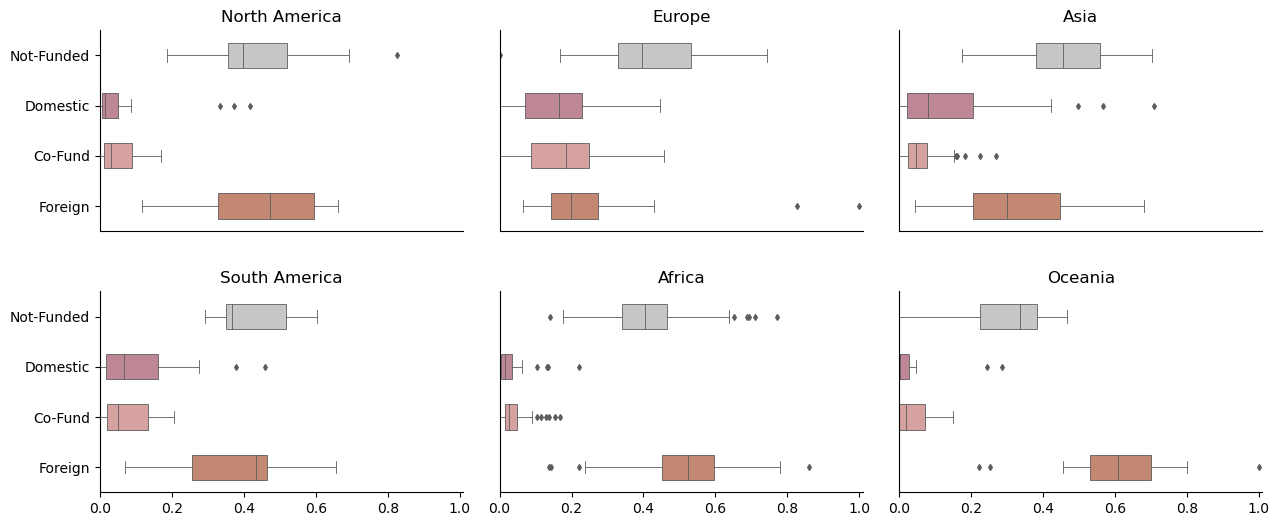

In [21]:
fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(15,6))
plt.subplots_adjust(wspace=0.1,hspace=0.3)

ax0=plot_region(fundtype,'North America',ax[0][0],1)
ax1=plot_region(fundtype,'Europe',ax[0][1])
ax2=plot_region(fundtype,'Asia',ax[0][2])
ax3=plot_region(fundtype,'South America',ax[1][0],1)
ax3.set_xticks(np.arange(0,1.2,0.2))
ax4=plot_region(fundtype,'Africa',ax[1][1])
ax4.set_xticks(np.arange(0,1.2,0.2))
ax5=plot_region(fundtype,'Oceania',ax[1][2])
ax5.set_xticks(np.arange(0,1.2,0.2))
plt.savefig(funding_portfolio_path,bbox_inches='tight')

In [22]:
selfund=fundtype.pivot(index=['cntry','region'],columns='fund',values='count').reset_index()
selfund['Funded']=1-selfund['Not-Funded']
selfund['DofF']=selfund['Domestic']/selfund['Funded'] #among the funded papers, the proportion that are exclusively funded by the country

In [24]:
selfund.sort_values(by='DofF')

fund,cntry,region,Co-Fund,Domestic,Foreign,Not-Funded,Funded,DofF
166,Somalia,Africa,0.000000,0.000000,0.517241,0.482759,0.517241,0.000000
133,Niue,Oceania,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000
157,Sao Tome & Principe,Africa,0.000000,0.000000,0.861111,0.138889,0.861111,0.000000
74,Guinea,Africa,0.010060,0.000000,0.615694,0.374245,0.625755,0.000000
39,Comoros,Africa,0.000000,0.000000,0.660714,0.339286,0.660714,0.000000
...,...,...,...,...,...,...,...,...
23,Brazil,South America,0.103905,0.458861,0.070052,0.367182,0.632818,0.725107
81,India,Asia,0.038028,0.351001,0.080243,0.530729,0.469271,0.747970
168,South Korea,Asia,0.076696,0.565427,0.071624,0.286253,0.713747,0.792195
83,Iran,Asia,0.019739,0.268847,0.049280,0.662134,0.337866,0.795720


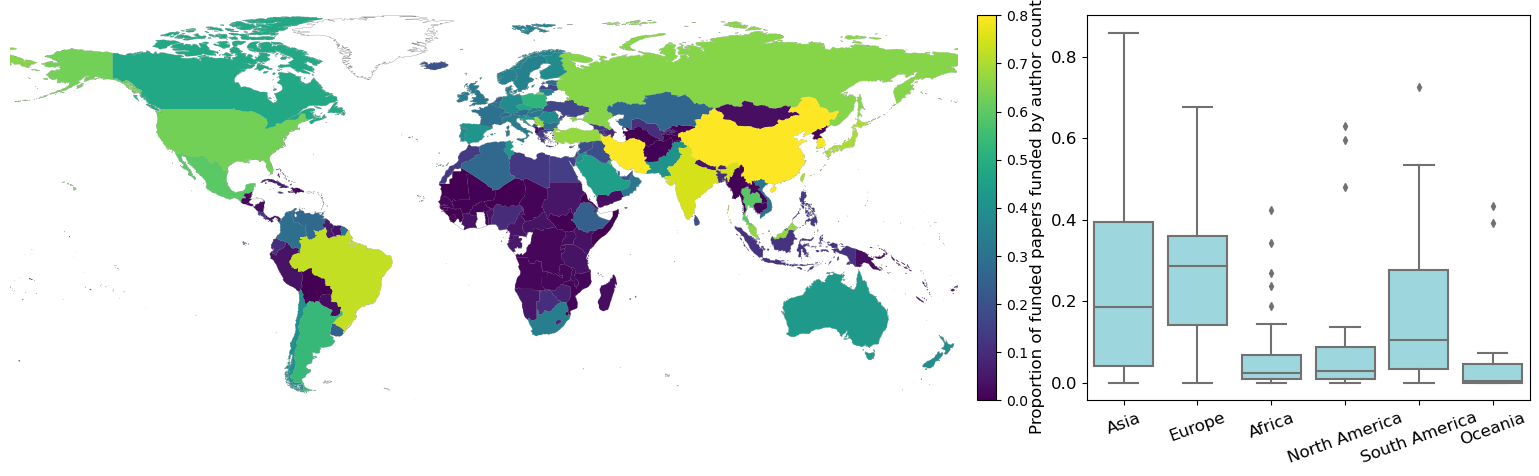

In [25]:
fig, ax = plt.subplots(1, 2, gridspec_kw={'width_ratios': [70, 30],'wspace': 0.1},figsize=(20,5))
plot_data=world_geo.merge(selfund,left_on='WoS',right_on='cntry')
plot_data=gp.GeoDataFrame(plot_data)
core.plot_worldmap(ax[0],fig, world_geo, plot_data, 'DofF','viridis',0.0,0.8)
ax[0].margins(0)

sns.boxplot(x='region',y='DofF',data=selfund,color='#92DFE6',
            order=['Asia','Europe','Africa','North America','South America','Oceania'],
            fliersize=4,
            ax=ax[1])
ax[1].set_ylabel('Proportion of funded papers funded by author country',fontsize=12)
ax[1].tick_params(axis='both', which='major', labelsize=12)
ax[1].set_xlabel('')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation = 20)
plt.savefig(funding_intensity_self_path,bbox_inches='tight')